In [2]:
from torch.utils.data import DataLoader
import random
import torch
from utils import load_file_list, collate_fn
from audio_classifier_pretrained import AudioClassifierWav2Vec
from audio_dataset import AudioDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


VALIADTION_BATCH_SIZE = 32

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)


train_file_paths = load_file_list('train_files.txt')
validation_file_paths = load_file_list('validation_files.txt')
test_file_paths = load_file_list('test_files.txt')

train_dataset = AudioDataset(train_file_paths)
validation_dataset = AudioDataset(validation_file_paths)
test_dataset = AudioDataset(test_file_paths)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
validation_laoder = DataLoader(validation_dataset, batch_size=VALIADTION_BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=VALIADTION_BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [4]:
model = AudioClassifierWav2Vec('facebook/wav2vec2-base-960h', num_labels=4)
model.fit(train_loader, validation_loader=validation_laoder, epochs=1, device='cpu')

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1:   0%|          | 0/233 [00:00<?, ?it/s]

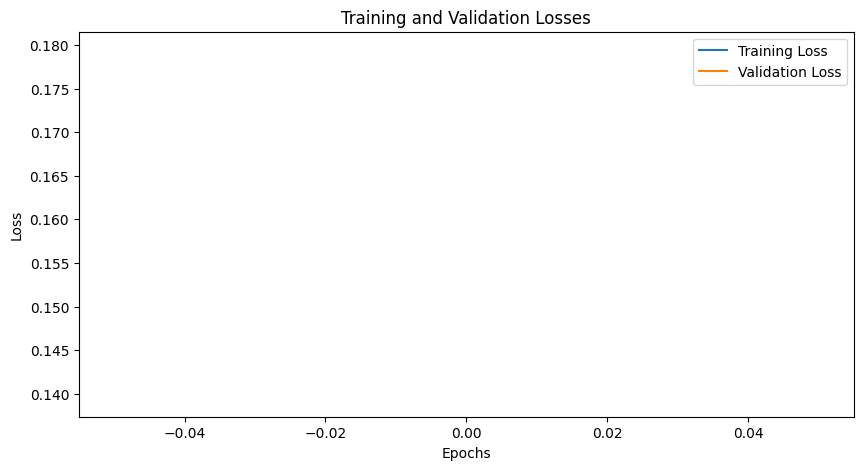

In [8]:
# Plotting directly from model attributes
plt.figure(figsize=(10, 5))
plt.plot(model.train_losses, label='Training Loss')
plt.plot(model.validation_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

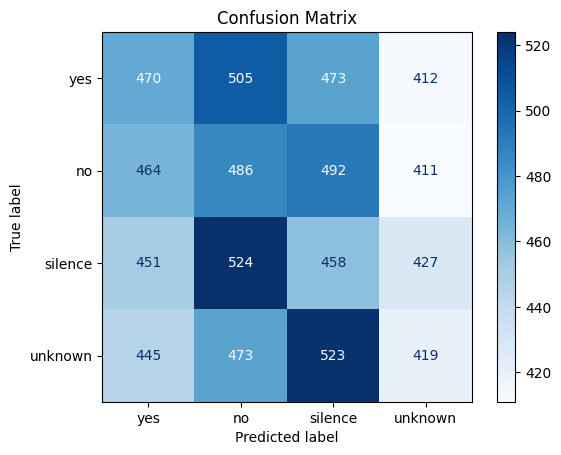

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(train_loader, device='cpu')

true_labels = []
for _, labels in train_loader:
    true_labels.extend(labels.numpy())

cm = confusion_matrix(true_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['yes', 'no', 'silence', 'unknown'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


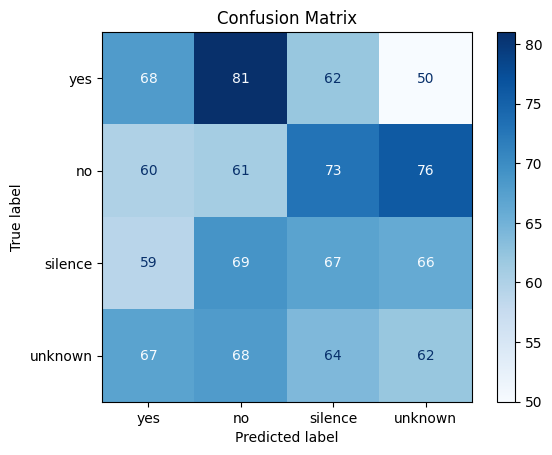

In [10]:
predictions = model.predict(validation_laoder, device='cpu')

true_labels = []
for _, labels in validation_laoder:
    true_labels.extend(labels.numpy())

cm = confusion_matrix(true_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['yes', 'no', 'silence', 'unknown'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


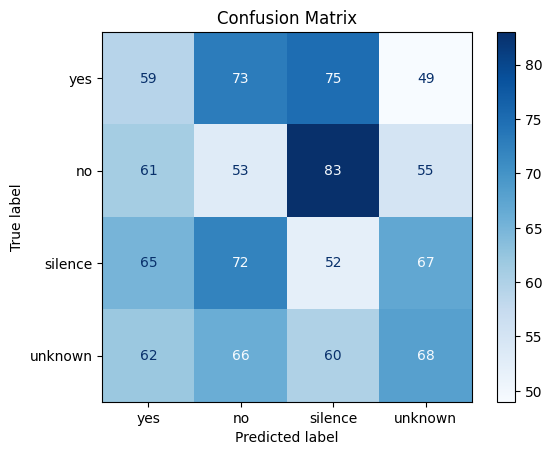

In [11]:
predictions = model.predict(test_loader, device='cpu')

true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.numpy())

cm = confusion_matrix(true_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['yes', 'no', 'silence', 'unknown'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# Zapisywanie modelu

In [12]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': model.optimizer.state_dict(),
    'scheduler_state_dict': model.scheduler.state_dict(),
    'train_losses': model.train_losses,
    'validation_losses': model.validation_losses,
}, 'model_checkpoint.pth')

# Load checkpoint
model = AudioClassifierWav2Vec(wav2vec_model_name='facebook/wav2vec2-base-960h', num_labels=4)
checkpoint = torch.load('model_checkpoint.pth')
# Load model, optimizer, and scheduler states
model.load_state_dict(checkpoint['model_state_dict'])
model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# If you also want to load the train and validation loss histories
model.train_losses = checkpoint['train_losses']
model.validation_losses = checkpoint['validation_losses']

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


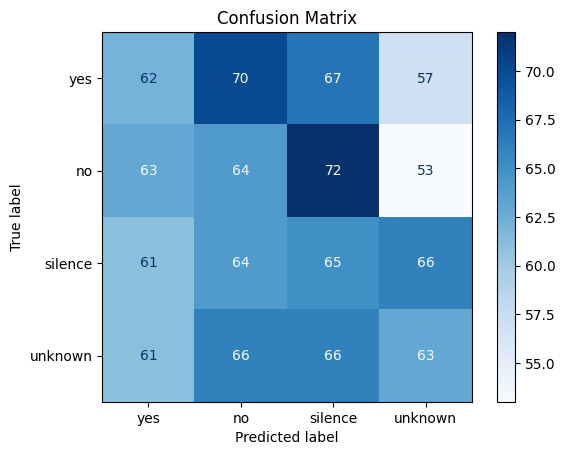

In [13]:
predictions = model.predict(test_loader, device='cpu')

true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.numpy())

cm = confusion_matrix(true_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['yes', 'no', 'silence', 'unknown'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
